In [340]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Estimación de una variable categórica

Plantearemos el problema de pesos y alturas, pero esta vez queremos estimar el género de la persona, en función de su peso y de su altura.  
Carguemos el dataset. Como las variables de los modelos son numéricas, vamos a transformar la columna "Sexo" de manera tal que el valor "Hombre" pasará a valer $0$ y el valor "Mujer" pasará a valer $1$.

In [296]:
import pandas as pd
df = pd.read_csv('alturas-pesos.csv')
df["Sexo"]=(df["Sexo"]!="Hombre").astype(int)
df.head() #Para visualizar las primeras 5 observaciones

,Sexo,Peso,Altura
0,0,109,187
1,0,73,174
2,0,96,188
3,0,99,182
4,0,93,177


Lo primero que podemos hacer en base a lo que conocemos, es intentar resolver este problema con una regresión lineal, utilizando como función de costo el error cuadrático medio. Los predictores son el peso y la altura. La respuesta deseada es el sexo.

In [297]:
import numpy as np
x1 = df['Peso'].values
x2 = df['Altura'].values
X=np.array([x1,x2]).transpose()
y = df['Sexo'].values
X

array([[109, 187],
       [ 73, 174],
       [ 96, 188],
       ...,
       [ 58, 162],
       [ 74, 175],
       [ 51, 157]])

In [314]:
import random
index=np.arange(10000)
np.random.shuffle(index)
X_train=X[index[:80]]
y_train=y[index[:80]]
X_test=X[index[80:100]]
y_test=y[index[80:100]]

import numpy as np
from keras.models import Sequential #Para poder definir un modelo secuencial
from keras.layers import Dense, BatchNormalization #Para poder usar capas densas
from keras.optimizers import SGD, Adam
model=Sequential() #Queda definido el modelo sequencia
model.add(Dense(1, input_shape=(2,)))
model.compile(optimizer=Adam(lr=0.01), loss='mse') #defino el MSE como función de costo y sgd como optimizador
# Train the model, iterating on the data in batches of 256 samples
history=model.fit(X_train, y_train, validation_data=[X_test,y_test],epochs=500,verbose=1, batch_size=64,shuffle = True) 

Train on 80 samples, validate on 20 samples
Epoch 1/500
80/80 [==============================] - 2s 21ms/step - loss: 20532.8156 - val_loss: 19708.8457
Epoch 2/500
80/80 [==============================] - 0s 75us/step - loss: 19449.0703 - val_loss: 18511.1074
Epoch 3/500
80/80 [==============================] - 0s 66us/step - loss: 18257.9141 - val_loss: 17305.7012
Epoch 4/500
80/80 [==============================] - 0s 56us/step - loss: 17061.6094 - val_loss: 16123.5098
Epoch 5/500
80/80 [==============================] - 0s 55us/step - loss: 15888.2377 - val_loss: 14977.0732
Epoch 6/500
80/80 [==============================] - 0s 55us/step - loss: 14754.7723 - val_loss: 13873.2324
Epoch 7/500
80/80 [==============================] - 0s 53us/step - loss: 13662.6834 - val_loss: 12816.5645
Epoch 8/500
80/80 [==============================] - 0s 56us/step - loss: 12618.4699 - val_loss: 11809.5947
Epoch 9/500
80/80 [==============================] - 0s 56us/step - loss: 11623.8492 - val_l

In [285]:
model.layers[0].get_weights()

[array([[ 0.10734223],
        [-0.05103211]], dtype=float32), array([1.2227856], dtype=float32)]

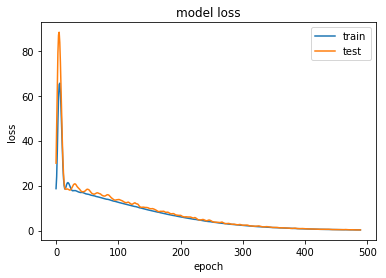

In [287]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'][10:500])
plt.plot(history.history['val_loss'][10:500])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [288]:
score=np.mean((model.predict(X_test)>0.5)==y_test)
print(score)

0.4


Viendo los resultados, parecerìa que el modelo no logra captar la naturaleza del problema. Veamos qué pasa con el umbral de decisión.

In [289]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_boundaries(X_train, X_test, y_train, y_test, score, probability_func, h = .02, ax = None):
    X = np.vstack((X_test, X_train))
    x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
    y_min, y_max = X[:, 1].min() - 10, X[:, 1].max() + 10
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    if ax is None:
        ax = plt.subplot(1, 1, 1)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    Z = probability_func(np.c_[xx.ravel(), yy.ravel()])#[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    cf = ax.contourf(xx, yy, Z, 50, cmap=cm, alpha=.8)
    plt.colorbar(cf, ax=ax)
    #plt.colorbar(Z,ax=ax)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k', s=100)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.6, s=200)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=40, horizontalalignment='right')


La regresión logística es un tipo de análisis de regresión utilizado para predecir el resultado de una variable categórica (una variable que puede adoptar un número limitado de categorías) en función de las variables independientes o predictores.


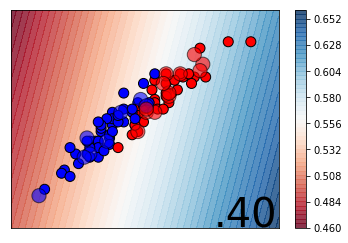

In [290]:
plot_boundaries(X_train, X_test, y_train, y_test, score, model.predict_proba, h = 0.2)

In [291]:
model.predict(X_test)[0:10]

array([[0.55360574],
       [0.5314554 ],
       [0.55907637],
       [0.57022697],
       [0.55700296],
       [0.5642161 ],
       [0.5735026 ],
       [0.56493646],
       [0.55805427],
       [0.5436573 ]], dtype=float32)

In [292]:
model.predict_proba(X_test)[0:10]

array([[0.55360574],
       [0.5314554 ],
       [0.55907637],
       [0.57022697],
       [0.55700296],
       [0.5642161 ],
       [0.5735026 ],
       [0.56493646],
       [0.55805427],
       [0.5436573 ]], dtype=float32)

In [293]:
y_test[0:10]

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1])

Veamos qué pasa en una dimensión

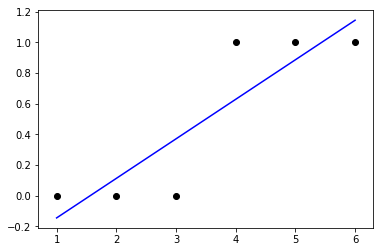

In [299]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
x2=np.array([[1],[2],[3],[4],[5],[6]])
y2=np.array([0,0,0,1,1,1])
model2=Sequential() #Queda definido el modelo sequencial
model2.add(Dense(1, input_shape=(1,)))
model2.compile(optimizer=Adam(lr=0.01), loss='mse') #defino el MSE como función de costo y sgd como optimizador
# Train the model, iterating on the data in batches of 256 samples
history=model2.fit(x2, y2,epochs=500,verbose=0, batch_size=64,shuffle = True) 
y_pred = model2.predict(x2)
plt.plot(x2, y_pred,  color='blue')
plt.scatter(x2, y2,  color='black')
plt.show()

En principio alcanzaría con establecer que si la salida de la predicción (h) es mayor que 0.5, la salida será 1, y si es menor que 0.5 la salida será cero. Agreguemos mas observaciones.

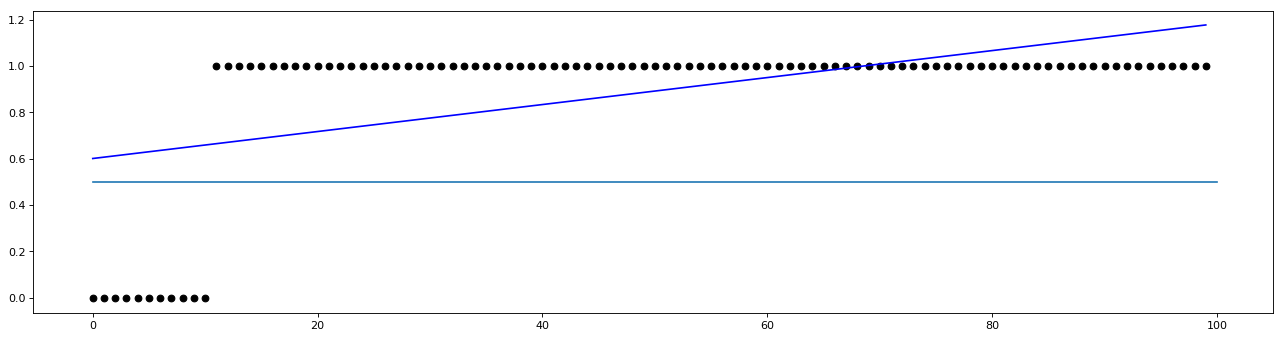

In [300]:
x2=np.array([[i] for i in range(0,100)])
y2=np.array([i>10 for i in range(0,100)])
model2=Sequential() #Queda definido el modelo sequencial
model2.add(Dense(1, input_shape=(1,)))
model2.compile(optimizer=Adam(lr=0.1), loss='mse') #defino el MSE como función de costo y sgd como optimizador
# Train the model, iterating on the data in batches of 256 samples
history=model2.fit(x2, y2,epochs=500,verbose=0, batch_size=64,shuffle = True) 
y_pred = model2.predict(x2)
figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x2, y_pred,  color='blue')
plt.plot([0,100],[0.5,0.5])
plt.scatter(x2, y2,  color='black')
plt.show()

En principio no parece que la regresión lineal sea una buena herramienta para encarar nuestro problema de regularización.
Para estos casos se utiliza la regresión logística, la hipótesis a partir de la cual establecemos nuestro modelo.
Modificaremos nuestra hipótesis $h_\omega(x)=\omega^T x$ y la modificaremos ligeramente a un caso mas genérico: $h_\omega(x)=g(\omega^T x)$. En el caso de la regresión logística:

$$g(z)=\frac{1}{1+e^{-z}}$$

Intuitivamente podemos decir que $g(z)$ es la probabilidad de que y=1 cuando los parámetros de entrada son x. Es decir:

$$g(z)=P(y=1|x;\omega)$$

Dado que se debe cumplir $P(y=0|x;\omega)+P(y=1|x;\omega)=1$, entonces podemos escribir a la probabilidad complementaria como:

$$P(y=0|x;\omega)=1-P(y=1|x;\omega)$$

Por lo tanto podemos analizar la salida $h_\omega(x)$ y decir que si $h_\omega(x)\geq0.5$ entonces y_pred=1. O bien y_pred=0 si 

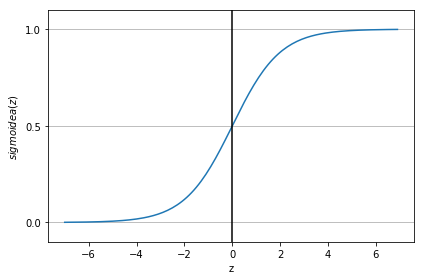

In [324]:
def inverse_log_odds(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = inverse_log_odds(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$sigmoidea (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

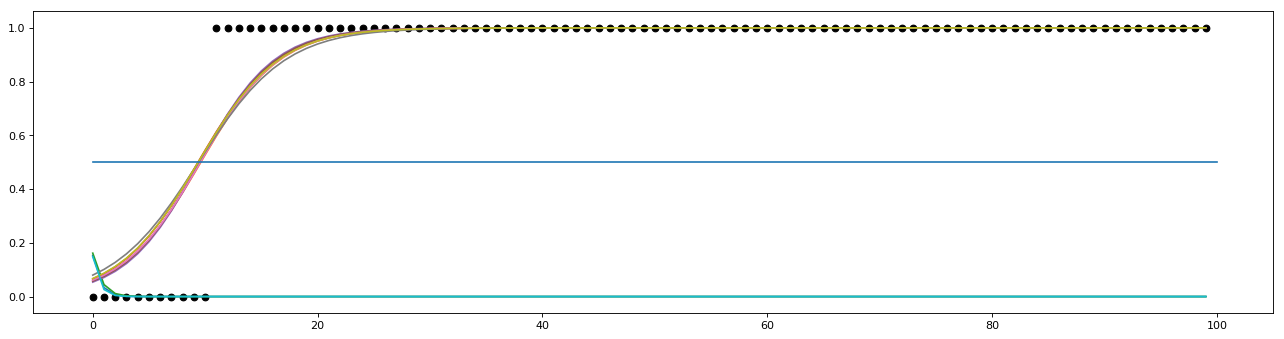

In [301]:
from sklearn.linear_model import LogisticRegression
x2=np.array([[i] for i in range(0,100)])
y2=np.array([i>10 for i in range(0,100)])
figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
for i in range(10):
    model2=Sequential() #Queda definido el modelo sequencial
    model2.add(Dense(1, input_shape=(1,),activation='sigmoid'))
    model2.compile(optimizer=Adam(lr=0.01), loss='mse') #defino el MSE como función de costo y sgd como optimizador
    # Train the model, iterating on the data in batches of 256 samples
    history=model2.fit(x2, y2,epochs=200,verbose=0, batch_size=64,shuffle = True) 
    y_pred = model2.predict(x2)
    plt.plot(x2, y_pred)
plt.plot([0,100],[0.5,0.5])
plt.scatter(x2, y2,  color='black')
plt.show()

Si bien las soluciones encontradas en general son mejores que la regresión lineal, vemos que a veces el algoritmo se estanca en soluciones que no son óptimas. Nótese que por el hecho de haber puesto la sigmoidea como función de activación, la función de costo ya no es mas cuadrática con respecto a los pesos. Esto hace que ya no podamos garantizar que la función de costo tenga un solo mínimo absoluto, sino que es posible que haya mínimos locales, o mesetas. Veamos cómo son los cortes de la función de costo variando cada parámetro del modelo por separado.

Tomemos un modelo bien entrenado, y veamos cómo nos dan los pesos.

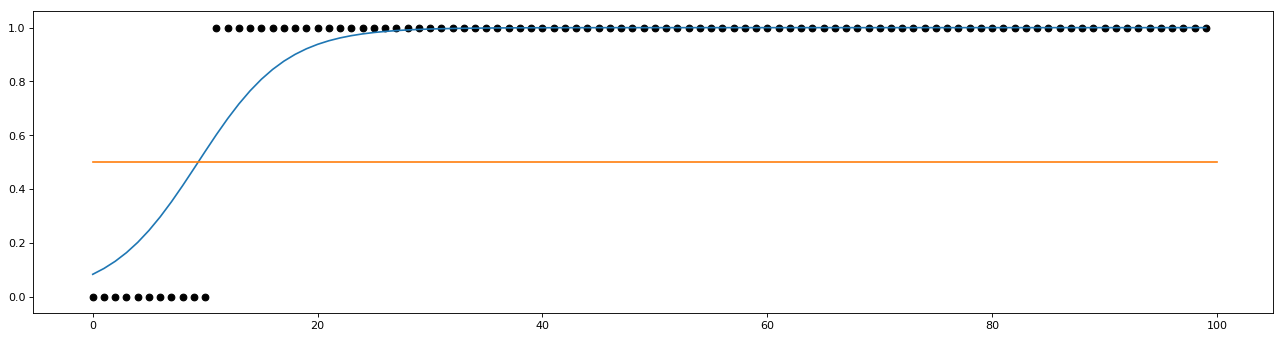

In [305]:
figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
model2=Sequential() #Queda definido el modelo sequencial
model2.add(Dense(1, input_shape=(1,),activation='sigmoid'))
model2.compile(optimizer=Adam(lr=0.01), loss='mse') #defino el MSE como función de costo y sgd como optimizador
# Train the model, iterating on the data in batches of 256 samples
history=model2.fit(x2, y2,epochs=200,verbose=0, batch_size=64,shuffle = True) 
y_pred = model2.predict(x2)
plt.plot(x2, y_pred)
plt.plot([0,100],[0.5,0.5])
plt.scatter(x2, y2,  color='black')
plt.show()

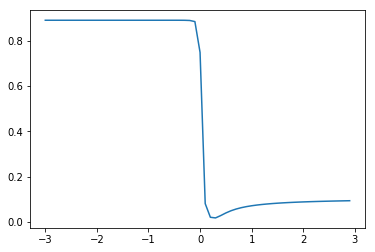

In [307]:
w_saved=model2.layers[0].get_weights()
weights=model2.layers[0].get_weights()
w_vec=np.arange(-3,3,.1)
loss=np.zeros(w_vec.shape)
for idx,w in enumerate(w_vec):
    weights[0][0][0]=w
    model2.set_weights(weights)
    loss[idx]=model2.evaluate(x2,y2,verbose=0)
plt.plot(w_vec,loss)
plt.show()

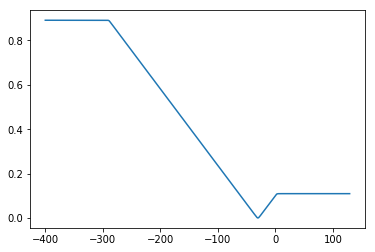

In [308]:
w_saved=model2.layers[0].get_weights()
weights=w_saved
w_vec=np.arange(-400,130,1)
loss=np.zeros(w_vec.shape)
for idx,w in enumerate(w_vec):
    weights[1][0]=w
    model2.set_weights(weights)
    loss[idx]=model2.evaluate(x2,y2,verbose=0)
plt.plot(w_vec,loss)
plt.show()

In [254]:
 weights[1][0]

129.0

(40,)
(50,)
(50, 40)
(50, 40)


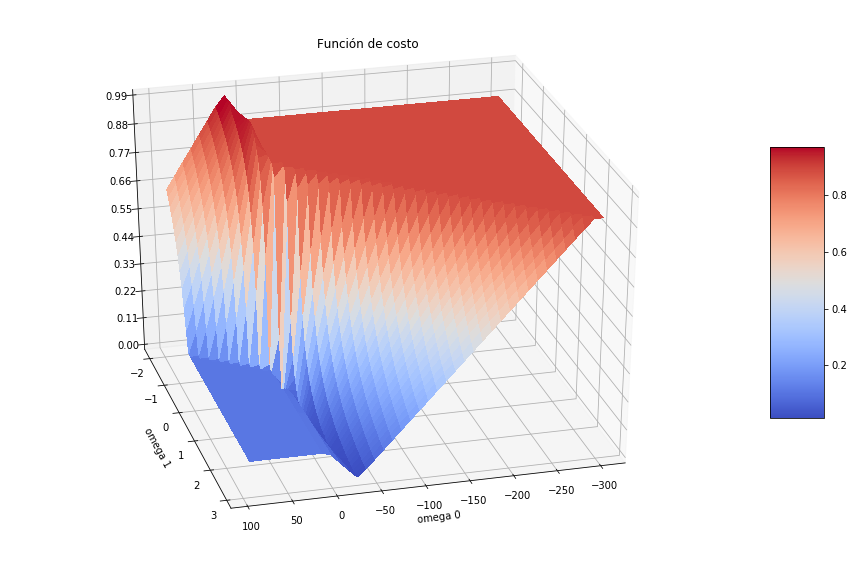

In [309]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')

# Make data.
omega0_v = np.arange(-300, 100, 10)
omega1_v = np.arange(-2, 3, 0.1)
print(omega0_v.shape)
print(omega1_v.shape)
omega0_var,omega1_var = np.meshgrid(omega0_v, omega1_v)
print(omega0_var.shape)
J=np.zeros(omega0_var.shape)
for i_o0,omega0 in enumerate(omega0_v):
    for i_o1,omega1 in enumerate(omega1_v):
        weights[0][0][0]=omega1
        weights[1][0]=omega0
        model2.set_weights(weights)
        J[i_o1,i_o0]=model2.evaluate(x2,y2,verbose=0)

#J=np.array(J)
#J=J.mean(axis=0)        
print(J.shape)
# Plot the surface.
surf = ax.plot_surface(omega0_var, omega1_var, J, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.plot(history[0,:],history[1,:],history[2,:])
ax.set_xlabel('omega 0')
ax.set_ylabel('omega 1')
ax.set_title('Función de costo')
#ax.scatter([])
# Customize the z axis.
#ax.set_zlim(0, 1000)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
# rotate the axes and update
angle=75
ax.view_init(30, angle)
plt.draw()
plt.pause(.001)


In [326]:
from keras.models import Sequential #Para poder definir un modelo secuencial
from keras.layers import Dense #Para poder usar capas densas
from keras.optimizers import SGD, Adam
model=Sequential() #Queda definido el modelo sequencial
model.add(Dense(1, input_shape=(2,),activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.01), loss='mse') #defino el MSE como función de costo y sgd como optimizador
# Train the model, iterating on the data in batches of 256 samples
history=model.fit(X_train, y_train, validation_data=[X_test,y_test],epochs=500,verbose=1, batch_size=64,shuffle = True) 

Train on 80 samples, validate on 20 samples
Epoch 1/500
80/80 [==============================] - 2s 22ms/step - loss: 0.3500 - val_loss: 0.3500
Epoch 2/500
80/80 [==============================] - 0s 100us/step - loss: 0.3500 - val_loss: 0.3500
Epoch 3/500
80/80 [==============================] - 0s 75us/step - loss: 0.3500 - val_loss: 0.3500
Epoch 4/500
80/80 [==============================] - 0s 82us/step - loss: 0.3500 - val_loss: 0.3500
Epoch 5/500
80/80 [==============================] - 0s 83us/step - loss: 0.3500 - val_loss: 0.3500
Epoch 6/500
80/80 [==============================] - 0s 75us/step - loss: 0.3500 - val_loss: 0.3500
Epoch 7/500
80/80 [==============================] - 0s 75us/step - loss: 0.3500 - val_loss: 0.3500
Epoch 8/500
80/80 [==============================] - 0s 74us/step - loss: 0.3500 - val_loss: 0.3500
Epoch 9/500
80/80 [==============================] - 0s 75us/step - loss: 0.3500 - val_loss: 0.3500
Epoch 10/500
80/80 [==============================] - 0

(80,)
(80,)
(80, 80)
(80, 80)


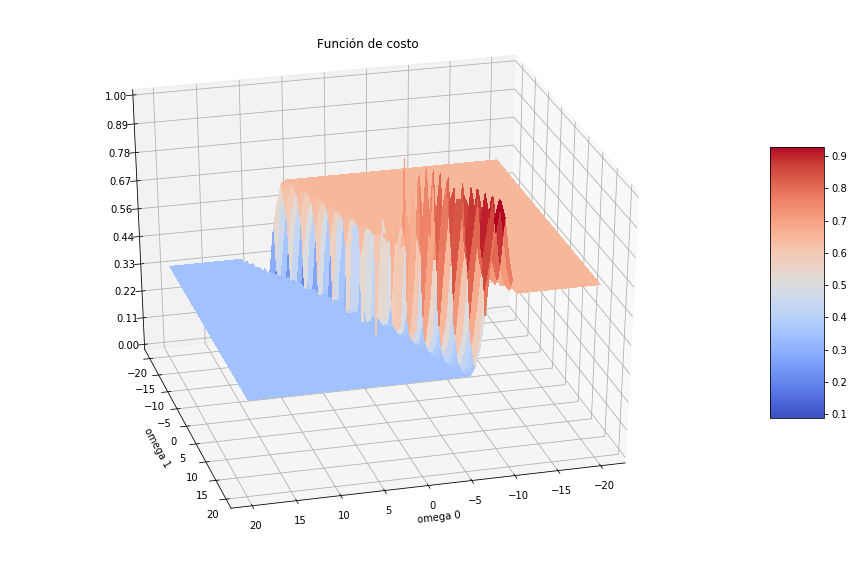

In [328]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
w_saved=model.layers[0].get_weights()
weights=model.layers[0].get_weights()

fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')

# Make data.
omega0_v = np.arange(-20, 20, 0.5)
omega1_v = np.arange(-20, 20, 0.5)
print(omega0_v.shape)
print(omega1_v.shape)
omega0_var,omega1_var = np.meshgrid(omega0_v, omega1_v)
print(omega0_var.shape)
J=np.zeros(omega0_var.shape)
for i_o0,omega0 in enumerate(omega0_v):
    for i_o1,omega1 in enumerate(omega1_v):
        weights[0][0][0]=omega1
        weights[0][1][0]=omega0
        #weights[1][0]=omega0
        model.set_weights(weights)
        J[i_o1,i_o0]=model.evaluate(X_train,y_train,verbose=0)

#J=np.array(J)
#J=J.mean(axis=0)        
print(J.shape)
# Plot the surface.
surf = ax.plot_surface(omega0_var, omega1_var, J, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.plot(history[0,:],history[1,:],history[2,:])
ax.set_xlabel('omega 0')
ax.set_ylabel('omega 1')
ax.set_title('Función de costo')
#ax.scatter([])
# Customize the z axis.
#ax.set_zlim(0, 1000)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
# rotate the axes and update
angle=75
ax.view_init(30, angle)
plt.draw()
plt.pause(.001)
model.layers[0].set_weights(w_saved)


In [329]:
weights

[array([[19.5],
        [19.5]], dtype=float32), array([0.], dtype=float32)]

# Regresión Logística

In [368]:
import pandas as pd
df = pd.read_csv('alturas-pesos.csv')
df["Sexo"]=(df["Sexo"]!="Hombre").astype(int)
df.head() #Para visualizar las primeras 5 observaciones

,Sexo,Peso,Altura
0,0,109,187
1,0,73,174
2,0,96,188
3,0,99,182
4,0,93,177


In [369]:
df.tail()

,Sexo,Peso,Altura
9995,1,62,168
9996,1,77,170
9997,1,58,162
9998,1,74,175
9999,1,51,157


In [416]:
import numpy as np
x1 = df['Peso'].values
#x1=x1-x1.mean()
#x1=x1/x1.std()
x2 = df['Altura'].values
#x2=x2-x2.mean()
#x2=x2/x2.std()
X=np.array([x1,x2]).transpose()
y = df['Sexo'].values
X

array([[109, 187],
       [ 73, 174],
       [ 96, 188],
       ...,
       [ 58, 162],
       [ 74, 175],
       [ 51, 157]])

In [417]:
import random
index=np.arange(10000)
np.random.shuffle(index)
X_train=X[index[:80]]
y_train=y[index[:80]]
X_test=X[index[80:10000]]
y_test=y[index[80:10000]]

In [419]:
import numpy as np
from keras.models import Sequential #Para poder definir un modelo secuencial
from keras.layers import Dense, BatchNormalization #Para poder usar capas densas
from keras.optimizers import SGD, Adam
model=Sequential() #Queda definido el modelo sequencial
model.add(BatchNormalization())
model.add(Dense(1, input_shape=(2,),activation='sigmoid'))
model.compile(optimizer=Adam(lr=1), loss='binary_crossentropy',metrics=['accuracy']) #defino el MSE como función de costo y sgd como optimizador
# Train the model, iterating on the data in batches of 256 samples
history=model.fit(X_train, y_train, validation_data=[X_test,y_test],epochs=500,verbose=1, batch_size=64,shuffle = True) 

Train on 80 samples, validate on 9920 samples
Epoch 1/500
80/80 [==============================] - 3s 31ms/step - loss: 0.7949 - acc: 0.2625 - val_loss: 0.4673 - val_acc: 0.8269
Epoch 2/500
80/80 [==============================] - 0s 3ms/step - loss: 0.5845 - acc: 0.8000 - val_loss: 0.6517 - val_acc: 0.7970
Epoch 3/500
80/80 [==============================] - 0s 4ms/step - loss: 0.6807 - acc: 0.8125 - val_loss: 0.6981 - val_acc: 0.7655
Epoch 4/500
80/80 [==============================] - 0s 5ms/step - loss: 0.5951 - acc: 0.7750 - val_loss: 0.5632 - val_acc: 0.7340
Epoch 5/500
80/80 [==============================] - 0s 4ms/step - loss: 0.5108 - acc: 0.7625 - val_loss: 0.5545 - val_acc: 0.7060
Epoch 6/500
80/80 [==============================] - 0s 4ms/step - loss: 0.5583 - acc: 0.7250 - val_loss: 0.3726 - val_acc: 0.8417
Epoch 7/500
80/80 [==============================] - 0s 4ms/step - loss: 0.4160 - acc: 0.8000 - val_loss: 0.3707 - val_acc: 0.8382
Epoch 8/500
80/80 [=================

KeyboardInterrupt: 

(60,)
(10,)
(10, 60)
(10, 60)


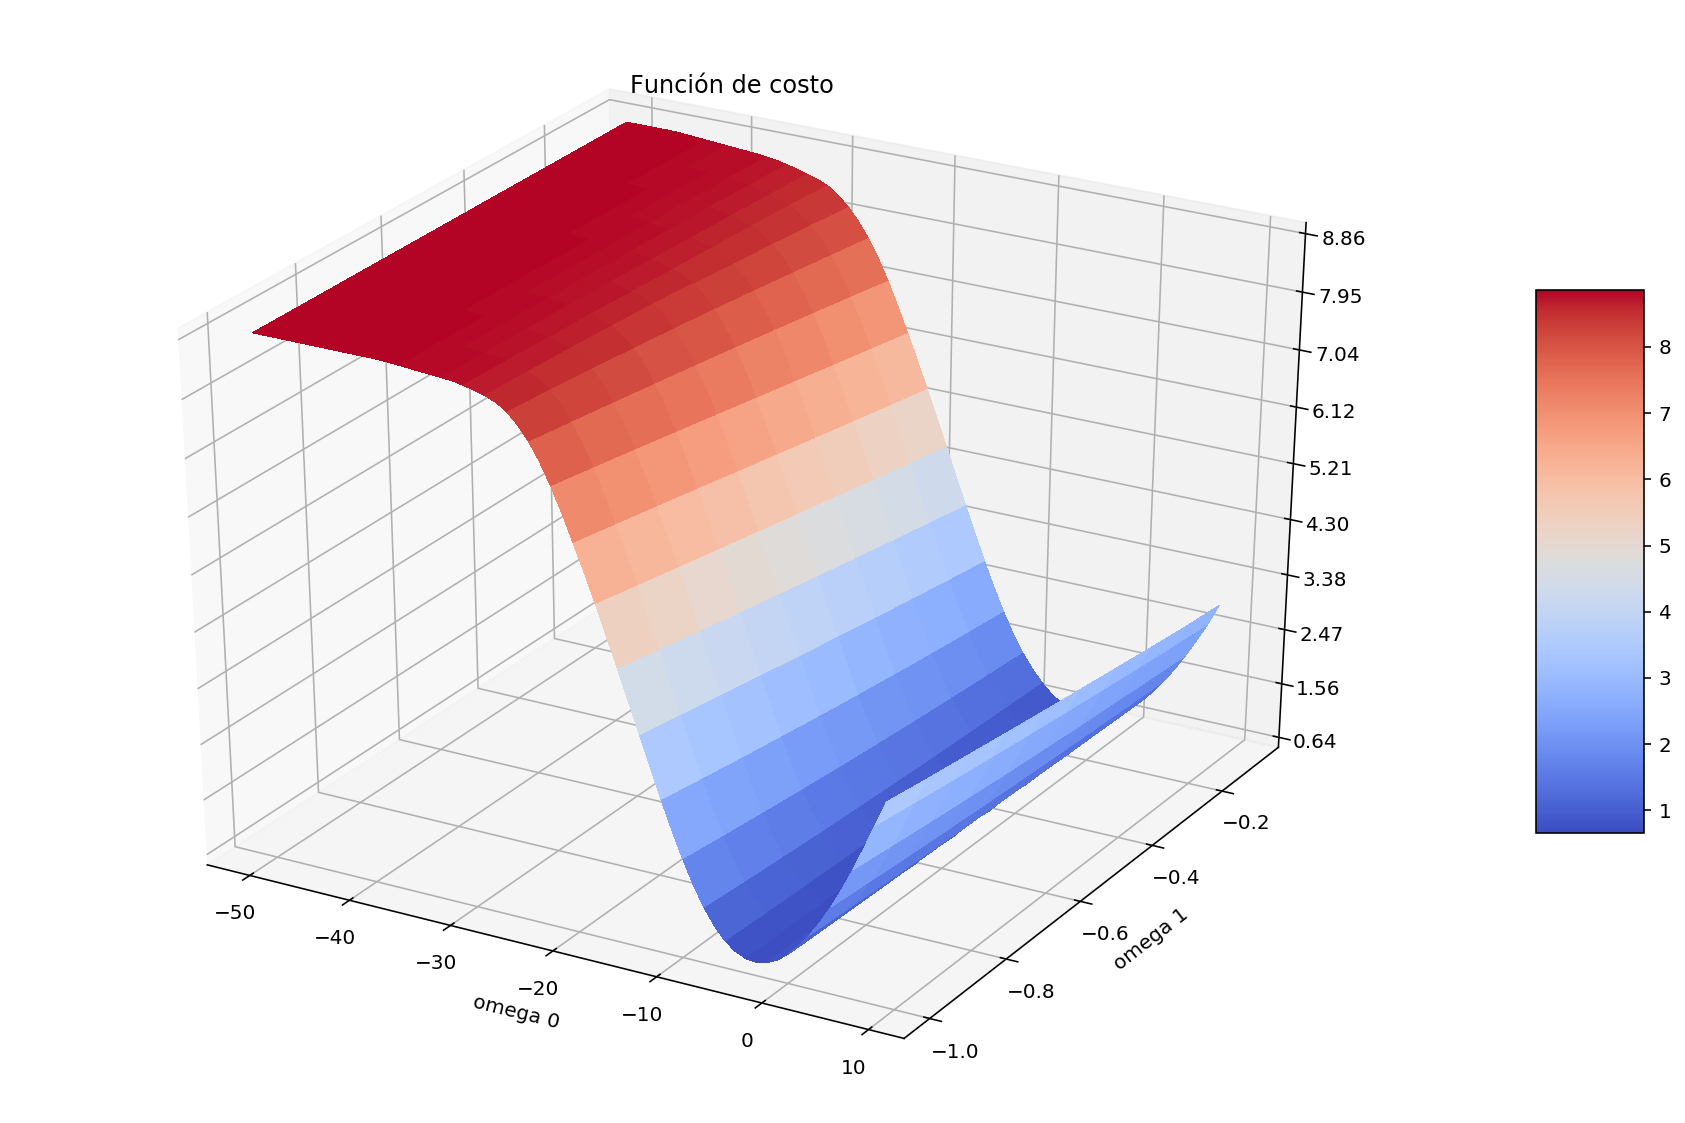

In [430]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
w_saved=model.layers[1].get_weights()
weights=model.layers[1].get_weights()

fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')

# Make data.
omega0_v = np.arange(-50, 10, 1)
omega1_v = np.arange(-1, 0, 0.1)
print(omega0_v.shape)
print(omega1_v.shape)
omega0_var,omega1_var = np.meshgrid(omega0_v, omega1_v)
print(omega0_var.shape)
J=np.zeros(omega0_var.shape)
for i_o0,omega0 in enumerate(omega0_v):
    for i_o1,omega1 in enumerate(omega1_v):
        weights[0][0][0]=omega1
        #weights[0][1][0]=omega0
        weights[1][0]=omega0
        model.layers[1].set_weights(weights)
        J[i_o1,i_o0]=model.evaluate(X_train,y_train,verbose=0)[0]

#J=np.array(J)
#J=J.mean(axis=0)        
print(J.shape)
# Plot the surface.
surf = ax.plot_surface(omega0_var, omega1_var, J, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.plot(history[0,:],history[1,:],history[2,:])
ax.set_xlabel('omega 0')
ax.set_ylabel('omega 1')
ax.set_title('Función de costo')
#ax.scatter([])
# Customize the z axis.
#ax.set_zlim(0, 1000)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
# rotate the axes and update
#angle=0
#ax.view_init(30, angle)
#plt.draw()
#plt.pause(.001)
plt.show()
model.layers[1].set_weights(w_saved)

In [427]:
model.layers[1].get_weights()

[array([[1.8852352 ],
        [0.43645614]], dtype=float32), array([-0.455511], dtype=float32)]